In [1]:
import matplotlib.pyplot as plt
import numpy as np
import utils as ut

# 1. Data importation and preparation

We work with the Law School Dataset: https://github.com/mkusner/counterfactual-fairness

In [2]:
pre_title = 'law_'

MyDirWithData='./'

[X_train, X_test, y_train, y_test, S_train, S_test,X_col_names]=ut.read_and_treat_law_data(MyDirWithData, display=True)

X_train = X_train.astype('float32')
y_train = y_train.ravel()
S_train = S_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.ravel()
S_test = S_test.astype('float32')

S_train.shape: (13109,)
X_train.shape: (13109, 3)
y_train.shape: (13109, 1)
S_test.shape: (6458,)
X_test.shape: (6458, 3)
y_test.shape: (6458, 1)


# 2. Counterfactual modeling

We compute two empirical counterfactual models: one on the training set, and one on the testing set. For every $s < s' \in \mathcal{S}$, it involves solving the program
$$
    \min_{\pi \in \Sigma(n_s,n_{s'})} \sum_{i \in \mathcal{I}_s} \sum_{j \in \mathcal{I}_{s'}} \pi[i,j] C[i,j],
$$
where

1. $C[i,j] = ||x_i - x_j||^2$,
2. $n_s = \sum^n_{i=1} \mathbf{1}_{\{s_i=s\}}$,
2. $I_s = \{ i=1,\ldots,n \mid s_i=s\}$.

In [3]:
model_train = ut.learn_cf(X_train,S_train)
model_test = ut.learn_cf(X_test,S_test)

# 3. Training regularized and baseline classifiers

The parameter $\lambda$ takes different values accross a grid. We store the evaluation metrics for each value of $\lambda$ and each baseline predictor.

In [4]:
param_list = [1e-4,10**(-3.5),1e-3,10**(-2.5),1e-2,10**(-1.5),10**(-1.25),10**(-1.1875),10**(-1.125),
              1e-1,10**(-0.5),1e0,10**(0.5),1e1]

MSE_list = []
KS_list = []
CFR_list = []
NVI_list = []

CCFL_list = []
OTCFL_list = []

In [5]:
epsilon = 0.5*np.mean(np.abs(y_test[:,None]-y_test[None,:]))
delta = 0.1

## 3.1. Unaltered predictor

Corresponds to $\lambda = 0$. Presumably the most accurate but also the most unfair predictor.

In [6]:
w = ut.train_regr(X_train,y_train)
y_pred = ut.regression(X_test,w)

MSE_list.append(ut.MSE(y_pred,y_test))
KS_list.append(ut.KS(y_pred,S_test))
CFR_list.append(ut.counterfactual_fairness_rate(y_pred,model_test,epsilon,delta))
NVI_list.append(np.std(y_pred)/np.std(y_test))

CCFL_list.append(ut.LinearSCM_CFL(w,S_test,X_test))
OTCFL_list.append(ut._counterfactual_loss(w,np.concatenate((np.ones((len(X_test),1)),X_test),axis=1),model_test)[0])

## 3.2. Penalized predictors

Corresponds to $\lambda > 0$. $\lambda$ governs a trade-off between accuracy and counterfactual fairness.

In [7]:
for reg in param_list:
    
    w = ut.train_regr(X_train,y_train,reg,model_train)
    y_pred = ut.regression(X_test,w)
    
    MSE_list.append(ut.MSE(y_pred,y_test))
    KS_list.append(ut.KS(y_pred,S_test))
    CFR_list.append(ut.counterfactual_fairness_rate(y_pred,model_test,epsilon,delta))
    NVI_list.append(np.std(y_pred)/np.std(y_test))
    
    CCFL_list.append(ut.LinearSCM_CFL(w,S_test,X_test))
    OTCFL_list.append(ut._counterfactual_loss(w,np.concatenate((np.ones((len(X_test),1)),X_test),axis=1),model_test)[0])

## 3.3. Best constant predictor

Corresponds to the mean target value.

In [8]:
y_pred = np.mean(y_train)*np.ones(len(y_test))

MSE_list.append(ut.MSE(y_pred,y_test))
KS_list.append(ut.KS(y_pred,S_test))
CFR_list.append(ut.counterfactual_fairness_rate(y_pred,model_test,epsilon,delta))
NVI_list.append(np.std(y_pred)/np.std(y_test))

CCFL_list.append(ut.LinearSCM_CFL(w,S_test,X_test))
OTCFL_list.append(ut._counterfactual_loss(w,np.concatenate((np.ones((len(X_test),1)),X_test),axis=1),model_test)[0])

## 4. Evaluation

We plot the evaluation metrics on a logarithmic scale.

In [9]:
param_scale = np.log10(param_list)

### 4.1. Prediction error

In [10]:
metric = MSE_list
title = 'Mean Square Error'

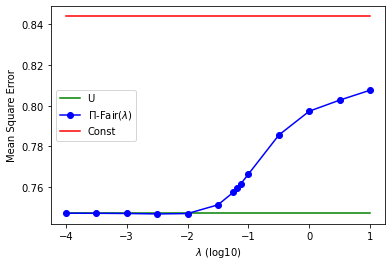

In [11]:
#Unfair
plt.plot(param_scale,[metric[0]]*len(param_scale), color='green', label='U')
#Trade-off
plt.plot(param_scale,metric[1:len(param_scale)+1],
         color='blue',linestyle='solid', marker='o', label='$\Pi$-Fair($\lambda$)')
#Fair
plt.plot(param_scale,[metric[-1]]*len(param_scale), color='red', label='Const')

plt.ylabel(title)
plt.xlabel('$\lambda$ (log10)')
plt.legend()
fig = plt.gcf()
plt.show()

### 4.2. Counterfactual fairness rate

In [12]:
metric = CFR_list
title = 'Counterfactual Fairness Rate'

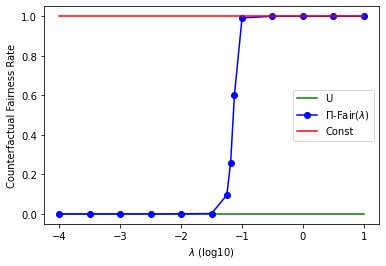

In [13]:
#Unfair
plt.plot(param_scale,[metric[0]]*len(param_scale), color='green', label='U')
#Trade-off
plt.plot(param_scale,metric[1:len(param_scale)+1],
         color='blue',linestyle='solid', marker='o', label='$\Pi$-Fair($\lambda$)')
#Fair
plt.plot(param_scale,[metric[-1]]*len(param_scale), color='red', label='Const')

plt.ylabel(title)
plt.xlabel('$\lambda$ (log10)')
plt.legend()
fig = plt.gcf()
plt.show()

### 4.3. Statistical parity

In [14]:
metric = KS_list
title = 'Kolmogorov-Smirnov'

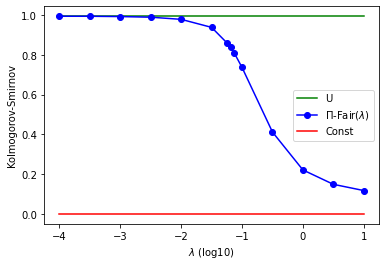

In [15]:
#Unfair
plt.plot(param_scale,[metric[0]]*len(param_scale), color='green', label='U')
#Trade-off
plt.plot(param_scale,metric[1:len(param_scale)+1],
         color='blue',linestyle='solid', marker='o', label='$\Pi$-Fair($\lambda$)')
#Fair
plt.plot(param_scale,[metric[-1]]*len(param_scale), color='red', label='Const')

plt.ylabel(title)
plt.xlabel('$\lambda$ (log10)')
plt.legend()
fig = plt.gcf()
plt.show()

### 4.4. Variations

In [16]:
metric = NVI_list
title = 'Standard Deviations'

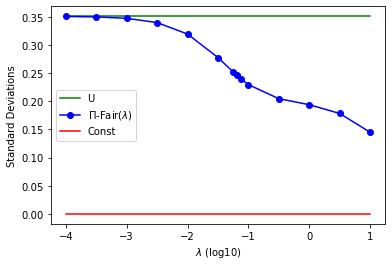

In [17]:
#Unfair
plt.plot(param_scale,[metric[0]]*len(param_scale), color='green', label='U')
#Trade-off
plt.plot(param_scale,metric[1:len(param_scale)+1],
         color='blue',linestyle='solid', marker='o', label='$\Pi$-Fair($\lambda$)')
#Fair
plt.plot(param_scale,[metric[-1]]*len(param_scale), color='red', label='Const')

plt.ylabel(title)
plt.xlabel('$\lambda$ (log10)')
plt.legend()
fig = plt.gcf()
plt.show()

# 5. The link with causal counterfactual fairness

In the next experiment, we show that enforcing transport-based counterfactual fairness promotes causal-based counterfactual fairness. We rely on the linear SCM proposed by [Kusner et. al., 2017], which enables to derive a closed-form for structural counterfactual operator.

In [18]:
metric1 = CCFL_list
metric2 = OTCFL_list
title1 = 'Causal Counterfactual Fairness Loss'
title2 = 'OT Counterfactual Fairness Loss'

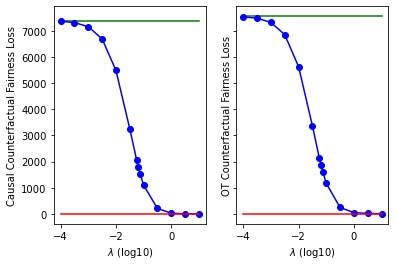

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True, sharey=True)

#Unfair
ax1.plot(param_scale,[metric1[0]]*len(param_scale), color='green', label='U')
#Trade-off
ax1.plot(param_scale,metric1[1:len(param_scale)+1],
         color='blue',linestyle='solid', marker='o', label='$\Pi$-Fair($\lambda$)')
#Fair
ax1.plot(param_scale,[metric1[-1]]*len(param_scale), color='red', label='Const')

ax1.set(xlabel='$\lambda$ (log10)', ylabel=title1)
#ax1.legend()

#Unfair
ax2.plot(param_scale,[metric2[0]]*len(param_scale), color='green', label='U')
#Trade-off
ax2.plot(param_scale,metric2[1:len(param_scale)+1],
         color='blue',linestyle='solid', marker='o', label='$\Pi$-Fair($\lambda$)')
#Fair
ax2.plot(param_scale,[metric2[-1]]*len(param_scale), color='red', label='Const')

ax2.set(xlabel='$\lambda$ (log10)', ylabel=title2)
#ax2.legend()


fig = plt.gcf()

plt.show()

As anticipated by the theory, the training process does promote causal counterfactual fairness. Importantly, this is not a consequence of the predictors merely becoming constant, as the sequence of aware predictions have variations that remain significantly higher than the best constant predictor.